# Description

This project was created to automatize the data post-processing which I get from my gas sensing setup. The setup consists of a set of gas pumps that mix the gas to the desired concentrations and pumps it to a gas chamber which can work with up to 4 sensors at one time. The setup reads the resistance of each sensor with a frequency of 1 Hz and writes them to a .csv file. The script reads a .csv file (an output of the setup), calculates the sensors' response, and plots the graphs. However, one needs to make a correct input of the parameters:
- set up the measurement temperature
- set the correct gas concentrations and its units (`ppm` or `ppb`)
- choose `separate concentrations` or `sequential concentrations` mode

**Future features:**
- Make code more efficient
- Reading temperature, gas conc. and gas name from the file name
- Implementation of ML approaches

# Reading the data

**Import necessary libraries**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import copy

%matplotlib inline
warnings.filterwarnings('ignore')

**Set up correct parameters**

In [2]:
temp = '70' # mesurement temperature
conc = [100, 500, 1000, 5000, 10000, 40000] # gas concentrations
conc_units = 'ppm' # gas concentration units
path = 'data/'+str(temp)+'C' # a path to a file according to temperature (a file should be named e.g. "50C") (modify just a folder name)
end = '.csv' # end of a file (do not modify)
mode = 1 # 1 for "Sequential concentrations", and 2 for "Separate concentrations"
mean_setting = 50 # a setting to calculate mean resistance based on last
csv_df = pd.read_csv(path+end, sep='\t+', skiprows=1, engine='python')

**Examples of different concentrations:**

- Aidin

[5000, 5000, 5000, 1] H2 CO2 CH4 NO2

[5000, 500, 1] H2 CO NO2

- Oleks

H2 (100, 500, 1000, 5000, 10000, 40000)

CO (10, 50, 100, 250, 500)

In [3]:
csv_df.head()

,Time [s],Sensor1 R [Ohm],Sensor2 R [Ohm],Sensor3 R [Ohm],Sensor4 R [Ohm],MFC 1 SP [mL/min],MFC 2 SP [mL/min],MFC 3 SP [mL/min],MFC 1 MassFlow [mL/min],MFC 2 MassFlow [mL/min],MFC 3 MassFlow [mL/min],MFC 1 MassFlow [vol%],MFC 2 MassFlow [vol%],MFC 3 MassFlow [vol%]
0,1.0,0.0,9.900000e+37,149948000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,0.0,9.900000e+37,149597000.0,0.0,150.0,0.0,0.0,1.219681,0.0,0.0,0.813121,0.0,0.0
2,3.0,0.0,9.900000e+37,149476000.0,0.0,150.0,0.0,0.0,149.260742,0.0,0.0,99.507161,0.0,0.0
3,4.0,0.0,9.900000e+37,148868000.0,0.0,150.0,0.0,0.0,149.483093,0.0,0.0,99.655396,0.0,0.0
4,5.0,0.0,9.900000e+37,148855000.0,0.0,150.0,0.0,0.0,149.576279,0.0,0.0,99.717519,0.0,0.0


# Data cleaning

In [4]:
# filling NaN values with zeros
csv_df.fillna(0, inplace=True)

# Changing seconds to hours and setting index column
csv_df['Time [h]'] = csv_df['Time [s]']/3600
#csv_df.set_index('Time [s]', inplace=True)

#replacing 9.9e+37 resistance values (overflow) with 1e+10
csv_df['Sensor1 R [Ohm]'].replace(9.900000e+37, 1e+10, inplace=True)
csv_df['Sensor2 R [Ohm]'].replace(9.900000e+37, 1e+10, inplace=True)
csv_df['Sensor3 R [Ohm]'].replace(9.900000e+37, 1e+10, inplace=True)
csv_df['Sensor4 R [Ohm]'].replace(9.900000e+37, 1e+10, inplace=True)

csv_df.head()

,Time [s],Sensor1 R [Ohm],Sensor2 R [Ohm],Sensor3 R [Ohm],Sensor4 R [Ohm],MFC 1 SP [mL/min],MFC 2 SP [mL/min],MFC 3 SP [mL/min],MFC 1 MassFlow [mL/min],MFC 2 MassFlow [mL/min],MFC 3 MassFlow [mL/min],MFC 1 MassFlow [vol%],MFC 2 MassFlow [vol%],MFC 3 MassFlow [vol%],Time [h]
0,1.0,0.0,1.000000e+10,149948000.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000278
1,2.0,0.0,1.000000e+10,149597000.0,0.0,150.0,0.0,0.0,1.219681,0.0,0.0,0.813121,0.0,0.0,0.000556
2,3.0,0.0,1.000000e+10,149476000.0,0.0,150.0,0.0,0.0,149.260742,0.0,0.0,99.507161,0.0,0.0,0.000833
3,4.0,0.0,1.000000e+10,148868000.0,0.0,150.0,0.0,0.0,149.483093,0.0,0.0,99.655396,0.0,0.0,0.001111
4,5.0,0.0,1.000000e+10,148855000.0,0.0,150.0,0.0,0.0,149.576279,0.0,0.0,99.717519,0.0,0.0,0.001389


# Getting the time stamps

In [5]:
# experiment time
exp_time = int(csv_df['Time [h]'].max())
rows, columns = csv_df.shape
first_row = csv_df.iloc[0,:]

#setting the first time stamp and the SP value
t_0 = first_row['Time [s]']
SP_0 = first_row['MFC 1 SP [mL/min]']

#print(f'time: {t_0}, SP: {SP_0}')
#print('time: {}, SP: {}'.format(t_0, SP_0))

#lists for time stamps and SP values
list_t = []
list_SP = []

#putting the first values into the lists
list_t.append(t_0)
list_SP.append(SP_0)

In [6]:
#going through all the values in Time and SP columns
for row in range(1, rows):
    t = csv_df.loc[row, 'Time [s]']
    SP = csv_df.loc[row, 'MFC 1 SP [mL/min]']
    #if current SP value is not equal to the last one in the SP_list, then write down new values into the time and sp lists
    if SP != list_SP[-1]:
        list_t.append(t)
        list_SP.append(SP)

In [7]:
#deleting some values coz we do not need them
list_t = list_t[1:]
list_SP = list_SP[1:]

In [8]:
#for a, b in zip(list_t, list_SP):
    #print(f'{a:0.4f} s, SP {b:0.4f}')

In [9]:
#Make a df out of the 2 lists
time_df = pd.DataFrame(list(zip(list_t, list_SP)), 
               columns =['Time', 'SP'])

# Some DataFrame modifications

In [10]:
#if mode is == 1, adding zero concentrations before the first and the last one
if mode==1:
    conc2=copy.deepcopy(conc)
    conc2.append(0)
    conc2.insert(0,0)

In [11]:
#if mode is == 2, adding zero concentrations between each gas concentration
if mode==2:
    
    conc2=copy.deepcopy(conc)
    i = 1
    while i < len(conc2):
        conc2.insert(i, 0)
        i += 2
    conc2.append(0)

In [12]:
#Cutting out unnecessary cells (the first and the last ones)
if mode==2:
    time_df.drop(time_df.head(1).index,inplace=True)

In [13]:
#Adding empty response columns to a df
for i in range(4):
    time_df['Sensor '+str(i+1)+' resp'] = 0

In [14]:
# #Adding empty init.resist columns to a df
# for i in range(4):
#     time_df['Sensor '+str(i+1)+' init. resist'] = resist_list[i]

In [15]:
# #Adding empty init. conc columns to a df
# for i in range(4):
#     time_df['Sensor '+str(i+1)+' init. conc.'] = 0

In [16]:
# #if the SP in the last row equals to zero - delete it
if time_df['SP'].iloc[-1]==0:
    time_df.drop(index=time_df.index[-1], 
        axis=0, 
        inplace=True)

In [17]:
#Adding gas concentrations to a df  # Previous version: time_df['Gas conc.'] = div_resist = conc2
time_df['Gas conc.'] = conc2 

# Initial resistivity calculation

In [18]:
# initial resistivity list is the mean value of the last 500 values before the 1st change of the SP for the each sensor

init_resist = []
init_resist_list = []
resp_resist = []
resp_resist_list = []
resist1 = 0
resist2 = 0

if mode == 1:
    for i in range(1,5):
        resist = csv_df.iloc[int(time_df['Time'][1]-mean_setting):int(time_df['Time'][1]),i].mean()
        # avoiding infinity in initial resistivity 
        if resist < 1.2e+9:
            init_resist.append(resist)
        else:
            resist = 1.2e+9
            init_resist.append(resist)
            
# Calculating both initial resistivity and response resist for mode 2
elif mode == 2:
    for i in range(1,5):
        init_resist = []
        resp_resist = []
        # going through all changes in SP
        for j in range(len(conc2)+1):
            # skipping the first row
            if j==0:
                continue
            # going through all changes in SP except of the first row
            else:
                # Calculating the initial resistivity
                if time_df['SP'][j]!=150:
                    resist1 = csv_df.iloc[int(time_df['Time'][j]-mean_setting):int(time_df['Time'][j]),i].mean()
                   #print('i =',i, ' j =',j, ' resist1 =',resist1)
                    # avoiding infinity in initial resistivity 
                    if resist1 < 1.2e+9:
                        init_resist.append(resist1)
                    else:
                        resist1 = 1.2e+9
                        init_resist.append(resist1)
                        
                # Calculating the response resistivity
                else:
                    resist2 = csv_df.iloc[int(time_df['Time'][j]-mean_setting):int(time_df['Time'][j]),i].mean()
                    #print('i =',i, ' j =',j, ' resist2 =',resist2)
                    # avoiding infinity in response resistivity 
                    if resist2 < 1.2e+9:
                        resp_resist.append(resist2)
                    else:
                        resist2 = 1.2e+9
                        resp_resist.append(resist2)
              
        init_resist_list.append(init_resist)
        resp_resist_list.append(resp_resist)

# Resistivity changes calculation

In [19]:
if mode==1:
# we have 4 sensors and should give data to all of them
    for i in range(1,5):
        #print('Sensor', i, 'initial res. = ', init_resist[i-1])
        # we need to go through all the changes in the resistivity
        for n in range(len(time_df)):
            #print('Gas conc. = ', time_df['H2 [ppm]'][n], 'ppm')
            if n+1<len(time_df):
                gas_res = round(csv_df.iloc[int(time_df['Time'][n+1]-mean_setting):int(time_df['Time'][n+1]),i].mean(), 3)
                #print('gas_res. = ',gas_res)
            else:
                continue
            #avoiding divison by zero
            if gas_res!=0:
                if init_resist[i-1]>gas_res:
                    div_resist = round(int(init_resist[i-1]) / gas_res, 3)
                    #print('div_resist = ',div_resist)
                    time_df.iloc[[n], [i+1]] = div_resist
                else:
                    div_resist = round(gas_res / int(init_resist[i-1]), 3)
                    time_df.iloc[[n], [i+1]] = div_resist
            else:
                time_df.iloc[[n], [i+1]] = 0

            
if mode==2:
    calc_resp_list=[]
    for i in range(len(init_resist_list)):
        response=[]
        for j in range(len(init_resist_list[1])):
            #print('init_resist_list[',i,'][',j,'] =', init_resist_list[i][j])
            #print('resp_resist_list[',i,'][',j,'] =', resp_resist_list[i][j])
            if resp_resist_list[i][j]==0 and init_resist_list[i][j]==0:
                response.append(0)
                #print('Response = ',0)
            else:
                #print('Response = ',resp_resist_list[i][j]/init_resist_list[i][j])
                response.append(round(resp_resist_list[i][j]/init_resist_list[i][j], 3))
        calc_resp_list.append(response)
    
    

In [20]:
if mode==2:
    time_df2 = pd.DataFrame(conc, columns=['Gas conc.'])
    for i in range(4):
        time_df2['Sensor '+str(i+1)+' resp'] = calc_resp_list[i]

In [21]:
# # Filling the time_df DataFrame with gas response values for each sensor
# if mode==2:
#     for i in range(len(calc_resp_list)):
#         for j in range(len(time_df)):
#             if time_df['Gas conc.'][j]!=0:
#                 time_df['Sensor ',[i],' resp'][j]=calc_resp_list[i][j] #iloc?
        

In [22]:
#Dropping first 2 rows from a DataFrame to avoid strange MFC values in the beginning of the plot
csv_df.drop([0, 1], inplace=True)

In [23]:
#Cutting out unnecessary cells (the first and the last ones)
if mode==1:
    time_df.drop(time_df.tail(1).index,inplace=True)
    time_df.drop(time_df.head(1).index,inplace=True)

In [24]:
time_df

,Time,SP,Sensor 1 resp,Sensor 2 resp,Sensor 3 resp,Sensor 4 resp,Gas conc.
1,36001.0,149.597992,0,4.069038e+07,1.136,0,100
2,39601.0,148.098007,0,4.658928e+07,1.154,0,500
3,43201.0,146.199005,0,4.858890e+07,1.130,0,1000
4,46801.0,131.199005,0,5.342832e+07,1.208,0,5000
5,50401.0,112.500000,0,5.515973e+07,1.287,0,10000
6,54001.0,0.000000,0,5.858803e+07,1.843,0,40000


# Plotting the data

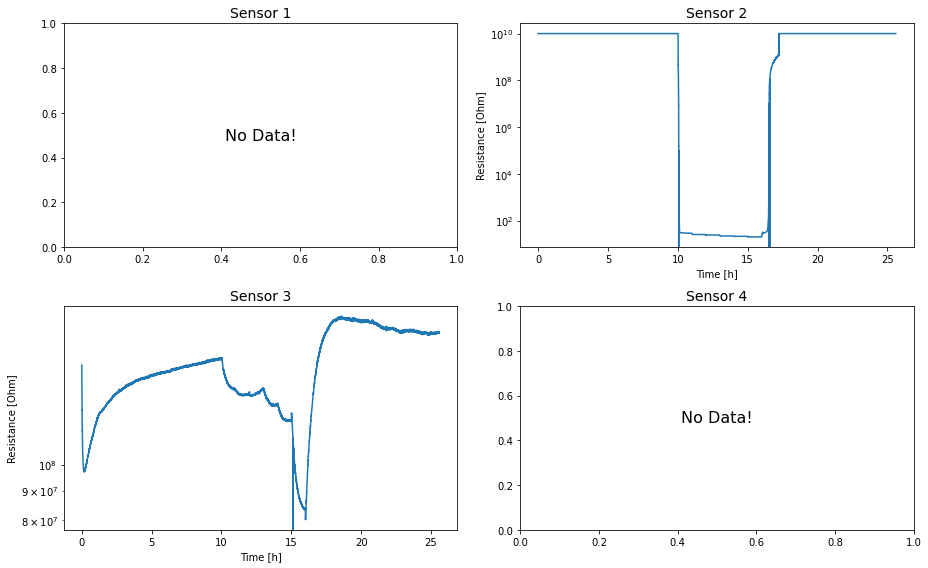

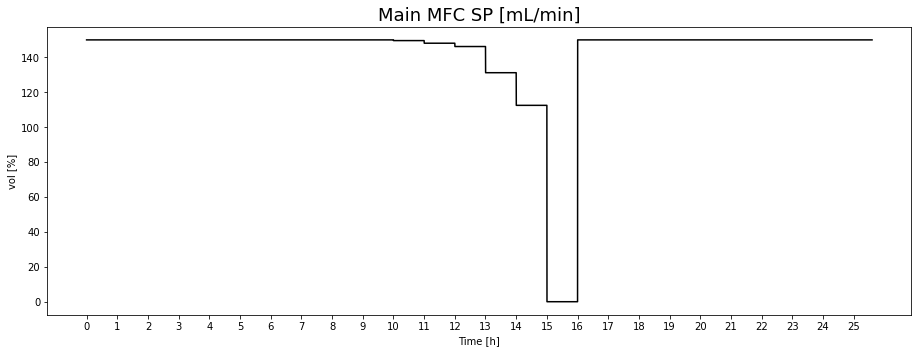

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(13,8))
counter = 0
for i in range(2):
    for j in range(2):
        if csv_df['Sensor'+str(counter+1)+' R [Ohm]'].mean() == 0:
            axes[i][j].text(0.5, 0.5, 'No Data!', weight = 'ultralight', horizontalalignment='center',
            verticalalignment='center', transform=axes[i][j].transAxes, fontsize=16)
            axes[i][j].set_title('Sensor '+str(counter+1)+'', fontsize=14)
            counter+=1
            continue
        else:
            axes[i][j].plot(csv_df['Time [h]'], csv_df['Sensor'+str(counter+1)+' R [Ohm]'])
            axes[i][j].set_ylabel('Resistance [Ohm]')
            axes[i][j].set_xlabel('Time [h]')
            axes[i][j].set_yscale('log')
            axes[i][j].set_title('Sensor '+str(counter+1)+'', fontsize=14)
            counter+=1


fig.tight_layout()

fig2 = plt.figure()
axes = fig2.add_axes([0, 0, 2, 1])
axes.plot(csv_df['Time [h]'], csv_df['MFC 1 SP [mL/min]'], 'black')
plt.setp(axes, xticks=np.arange(0, exp_time+1, 1))
plt.xlabel('Time [h]')
plt.ylabel('vol [%]')
plt.title('Main MFC SP [mL/min]', fontsize=18)

plt.show()
fig.savefig(path+'_Overall_result.png', dpi=fig.dpi)
fig2.savefig(path+'_MFC_setup.png', dpi=fig.dpi, bbox_inches='tight')

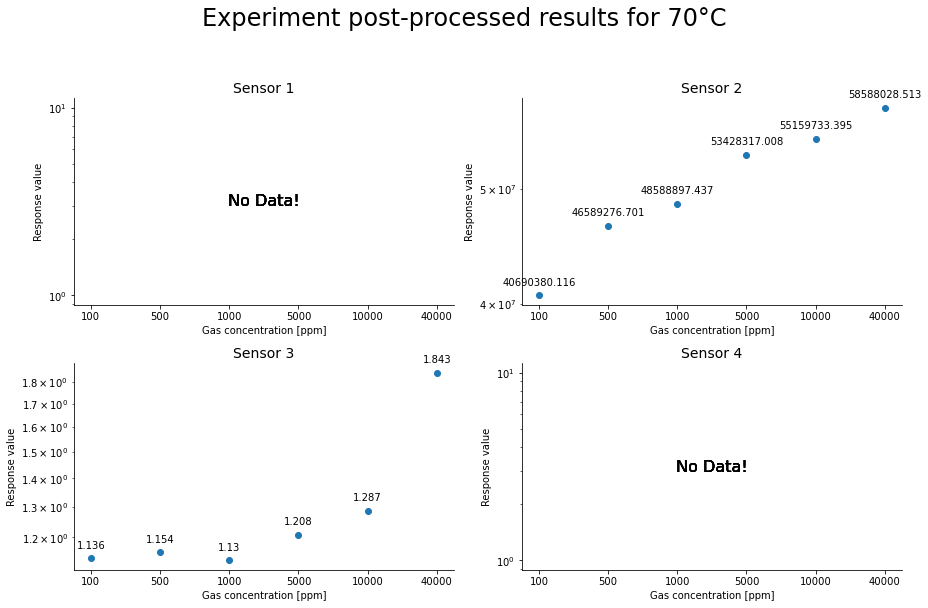

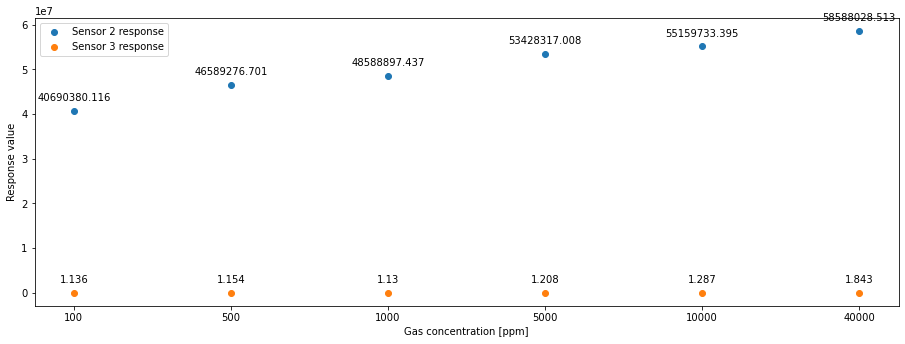

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(13,8))

# Plotting the graphs
counter = 0
for i in range(2):
    for j in range(2):
        
        # Plotting the graphs
        if mode==1:
            axes[i][j].scatter(time_df['Gas conc.'].astype('str'), time_df['Sensor '+str(counter+1)+' resp'])
        if mode==2:
            axes[i][j].scatter(time_df2['Gas conc.'].astype('str'), time_df2['Sensor '+str(counter+1)+' resp'])
        #Removing graph's unnecessary  lines
        axes[i][j].spines['right'].set_visible(False)
        axes[i][j].spines['top'].set_visible(False)
        
        #Setting the labels and a titles
        axes[i][j].set_ylabel('Response value')
        axes[i][j].set_xlabel('Gas concentration ['+str(conc_units)+']')
        axes[i][j].set_title('Sensor '+str(counter+1)+'', fontsize=14)
        
        #Setting the scale
        axes[i][j].set_yscale('log')
        
        # Making response annotations for the scatter graphs
        if mode==1:
            for x,y in zip(time_df['Gas conc.'].astype('str'), time_df['Sensor '+str(counter+1)+' resp']):
                if y == 0:
                    axes[i][j].text(0.5, 0.5, 'No Data!', weight = 'ultralight', horizontalalignment='center',
                        verticalalignment='center', transform=axes[i][j].transAxes, fontsize=16)
                    continue
                axes[i][j].annotate(y, # this is the text
                    (x,y), # this is the point to label
                    textcoords="offset points", # how to position the text
                    xytext=(0,10), # distance from text to points (x,y)
                    ha='center') # horizontal alignment can be left, right or center
            counter+=1
        if mode==2:
            for x,y in zip(time_df2['Gas conc.'].astype('str'), time_df2['Sensor '+str(counter+1)+' resp']):
                if y == 0:
                    axes[i][j].text(0.5, 0.5, 'No Data!', weight = 'ultralight', horizontalalignment='center',
                        verticalalignment='center', transform=axes[i][j].transAxes, fontsize=16)
                    continue
                axes[i][j].annotate(y, # this is the text
                    (x,y), # this is the point to label
                    textcoords="offset points", # how to position the text
                    xytext=(0,10), # distance from text to points (x,y)
                    ha='center') # horizontal alignment can be left, right or center
            counter+=1

fig.suptitle("Experiment post-processed results for "+ str(temp) + "°C", fontsize=24, y=1.05)
fig.tight_layout()


# Making another graph
fig2 = plt.figure()
ax2 = fig2.add_axes([0, 0, 2, 1])
ax2.set_yscale('linear')

# Plotting the graph2
counter = 0
for i in range(4):
    # Plotting another graph with all responces combined if their values are not just zeros
    if mode==1:
        if time_df['Sensor '+str(i+1)+' resp'].sum()!=0:
            ax2.scatter(time_df['Gas conc.'].astype('str'),
                    time_df['Sensor '+str(i+1)+' resp'], 
                    label='Sensor '+str(i+1)+' response')
        # Making response annotations for the scatter graph (fig2)
        for x,y in zip(time_df['Gas conc.'].astype('str'), time_df['Sensor '+str(counter+1)+' resp']):
            if y == 0:
                continue
            ax2.annotate(y, # this is the text
                (x,y), # this is the point to label
                textcoords="offset points", # how to position the text
                xytext=(0,10), # distance from text to points (x,y)
                ha='center') # horizontal alignment can be left, right or center
        counter+=1
    if mode==2:
        if time_df2['Sensor '+str(i+1)+' resp'].sum()!=0:
            ax2.scatter(time_df2['Gas conc.'].astype('str'),
                    time_df2['Sensor '+str(i+1)+' resp'], 
                    label='Sensor '+str(i+1)+' response')
        # Making response annotations for the scatter graph (fig2)
        for x,y in zip(time_df2['Gas conc.'].astype('str'), time_df2['Sensor '+str(counter+1)+' resp']):
            if y == 0:
                continue
            ax2.annotate(y, # this is the text
                (x,y), # this is the point to label
                textcoords="offset points", # how to position the text
                xytext=(0,10), # distance from text to points (x,y)
                ha='center') # horizontal alignment can be left, right or center
        counter+=1
plt.legend();
ax2.set_ylabel('Response value')
ax2.set_xlabel('Gas concentration ['+str(conc_units)+']')

fig.tight_layout()
fig.savefig(path+'_Response_result.png', dpi=fig.dpi)
fig2.savefig(path+'_Response_result_all.png', dpi=fig.dpi, bbox_inches = 'tight')

# Saving the data

In [27]:
if mode==1:
    time_df.to_excel(path+' Excel Results.xlsx', index = False)
if mode==2:
    time_df2.to_excel(path+' Excel Results.xlsx', index = False)